### Setup

In [133]:
import json, time, pickle
from functools import reduce

import pandas as pd
import numpy as np

from ast import literal_eval

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from tqdm.autonotebook import tqdm

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='whitegrid')

import matplotlib.pyplot as plt

from py2neo import Graph, Node, Relationship

In [5]:
# public_address = '54.174.175.98'
public_address = '54.88.167.164'

graph = Graph('bolt://{}:7687'.format(public_address), auth=('neo4j','myneo'))

def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False, verbose=True):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    if verbose:
        print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df


In [6]:
years_to_consider = range(1900, 2020)
max_years_to_predict = 10
years_tracked = 10

vars_to_use = ['adopters', 'timeScaledPageRank', 'citatons', 'node2vec']

max_year = max(years_to_consider)
min_year = min(years_to_consider)

### Write data to CSV

In [7]:
metrics_pattern = 'MATCH (q)-[m{y}:METRICS_IN]->(:Year {{year:y.year+{y}}})'
metrics_string_list = [metrics_pattern.format(y=i) for i in range(years_tracked+1)]
metrics_string = '\n'.join(metrics_string_list)

var_pattern = 'coalesce(m{y}.{v},0) AS {v}_{y},'
var_string_list = [var_pattern.format(y=i,v=j) for i in range(years_tracked+1) for j in vars_to_use]
var_string = '\n'.join(var_string_list)

where_pattern = 'exists(m{y}.node2vec)'
where_string_list = [where_pattern.format(y=i) for i in range(years_tracked+1)]
where_string = ' AND '.join(where_string_list)       

author_metrics_pattern = 'MATCH (q)-[ma{y}:METRICS_IN]->(:Year {{year:y.year+{y}}})'
author_metrics_string_list = [author_metrics_pattern.format(y=i) for i in range(years_tracked+1)]
author_metrics_string = '\n'.join(author_metrics_string_list)

author_vars = ['total_papers', 'author_age', 'max_citations', 'num_venues', 'total_citations']
author_funs = ['max', 'sum']
author_var_pattern = '{f}(coalesce(ma{y}.{v},0)) AS {v}_{f}_{y},'
author_var_string_list = [author_var_pattern.format(y=i, v=j, f=k)
                          for i in range(years_tracked+1)
                          for j in author_vars
                          for k in author_funs]
author_var_string = '\n'.join(author_var_string_list)


query = """
MATCH (a:Author)-[:AUTHORED]->(q:Quanta)-[:PUBLISHED_IN]->(y:Year)
WHERE y.year>={miny} AND y.year<={maxy}//-{ya}
{metrics_string}
{author_metrics_string}
WHERE {where_string}
RETURN 
    {var_string}
    {author_var_string}
    id(q) AS id, 
    y.year AS year
""".format(miny=min_year, 
           maxy=max_year,
           ya=max_years_to_predict,
           metrics_string=metrics_string,
           var_string=var_string, 
           where_string=where_string, 
           author_metrics_string='',
           author_var_string='')

query_tocsv = """
CALL apoc.export.csv.query('
{q}
','/import/quanta.predict.{miny}.{maxy}.csv', 
{{quotes:true}});
""".format(q=query, 
           miny=min_year, 
           maxy=max_year,
           yt=years_tracked)

run_query(query_tocsv, graph, to_df=False, print_only=True)


CALL apoc.export.csv.query('

MATCH (a:Author)-[:AUTHORED]->(q:Quanta)-[:PUBLISHED_IN]->(y:Year)
WHERE y.year>=1900 AND y.year<=2019//-10
MATCH (q)-[m0:METRICS_IN]->(:Year {year:y.year+0})
MATCH (q)-[m1:METRICS_IN]->(:Year {year:y.year+1})
MATCH (q)-[m2:METRICS_IN]->(:Year {year:y.year+2})
MATCH (q)-[m3:METRICS_IN]->(:Year {year:y.year+3})
MATCH (q)-[m4:METRICS_IN]->(:Year {year:y.year+4})
MATCH (q)-[m5:METRICS_IN]->(:Year {year:y.year+5})
MATCH (q)-[m6:METRICS_IN]->(:Year {year:y.year+6})
MATCH (q)-[m7:METRICS_IN]->(:Year {year:y.year+7})
MATCH (q)-[m8:METRICS_IN]->(:Year {year:y.year+8})
MATCH (q)-[m9:METRICS_IN]->(:Year {year:y.year+9})
MATCH (q)-[m10:METRICS_IN]->(:Year {year:y.year+10})

WHERE exists(m0.node2vec) AND exists(m1.node2vec) AND exists(m2.node2vec) AND exists(m3.node2vec) AND exists(m4.node2vec) AND exists(m5.node2vec) AND exists(m6.node2vec) AND exists(m7.node2vec) AND exists(m8.node2vec) AND exists(m9.node2vec) AND exists(m10.node2vec)
RETURN 
    coalesce(m0.adopte

1

### Read in data for each year, format it, and write it back

In [39]:
fpath = '/tmp/data/quanta.predict.{miny}.{maxy}.{yt}.csv'.format(
    miny=min_year, maxy=max_year, yt=years_tracked, ya=years_ahead)
df = pd.read_csv(fpath, engine='python', error_bad_lines=False)
df = df.dropna()

for y in tqdm(range(years_tracked+1)):

    col = 'node2vec_{}'.format(y)    
    n2vdf = pd.DataFrame(df[col].apply(json.loads).tolist())
    n2v_dim = n2vdf.shape[1]
    n2vdf.columns = ['{}_{}'.format(col, i) for i in range(n2v_dim)]

    df = pd.concat([df.reset_index(drop=True), n2vdf.reset_index(drop=True)], axis=1)
    df = df.drop(col, axis=1)


df.to_csv('{}.out'.format(fpath))

NameError: name 'years_ahead' is not defined

### Read in prediction data and make predictions

In [155]:
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, mean_squared_error, classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.externals.joblib import parallel_backend

from xgboost import XGBClassifier, XGBRegressor
from multiprocessing import set_start_method
import os
os.environ["OMP_NUM_THREADS"] = "40"

sns.set(rc={'figure.figsize':(15,10)})
sns.set(style='whitegrid')

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [8]:
df = pd.read_csv('/tmp/data/quanta.predict.1900.2017.10.csv.out')

In [460]:
max_years_to_predict = 10
years_tracked = 10
n2v_dim = 12

results = []

for years_to_track in tqdm(range(years_tracked)):
#     for year_to_predict in range(years_to_track+1, max_years_to_predict+1):
#         print(years_to_track, year_to_predict)
#         pass
    year_to_predict = years_to_track + 1
    
    cols_to_keep = ['{v}_{y}'.format(y=i,v=j) 
        for i in range(years_to_track+1) 
        for j in [v for v in vars_to_use if v!='node2vec']]

    n2v_cols_to_keep =  ['node2vec_{y}_{i}'.format(y=y, i=i) 
                     for y in range(years_to_track+1)
                     for i in range(n2v_dim)]

    cols_to_keep = cols_to_keep + n2v_cols_to_keep
    X = df.loc[:, cols_to_keep]

    y_col = 'timeScaledPageRank_{y}'.format(y=year_to_predict)
    y = df.loc[:, y_col] > df[y_col].quantile(q=.95)


    pipeline = Pipeline(
        memory=None,
        steps=[
            ('spl', SMOTE()),
            ('scl', QuantileTransformer()),
            ('clf', RandomForestClassifier())
        ]
    )

    grid = {
        'clf__n_estimators': [int(x) for x in np.linspace(50, 2000, num=10)],
        'clf__max_features': ['auto', 'sqrt'],
#         'clf__max_depth': [int(x) for x in np.linspace(10, 1000, num=10)],
        'clf__min_samples_split': [2, 5, 10, 20],
        'clf__min_samples_leaf': [1, 2, 4, 10, 20],
        'clf__bootstrap': [True, False]
    }

    random_search = RandomizedSearchCV(
        estimator=pipeline, 
        param_distributions=grid, 
        n_iter=10, 
        scoring='accuracy',
        cv=3, 
        n_jobs=-1,
        verbose=3,
        random_state=42
    )


    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    with parallel_backend('threading'):
        random_search.fit(X_train, y_train)

    y_pred = random_search.predict(X_test)

    results.append({
        'years_tracked': years_to_track, 
        'year_predicted': year_to_predict,
        'score': random_search.score(X=X_test, y=y_test),
        'f1': f1_score(y_pred=y_pred, y_true=y_test),
        'balanced_accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_pred),
        'balanced_accuracy_adjusted': balanced_accuracy_score(y_true=y_test, y_pred=y_pred, adjusted=True),
        'classification_report': classification_report(y_true=y_test, y_pred=y_pred, output_dict=True),
        'random_search': random_search
    })

    pickle.dump(results, open('prediction_models_{}.pickle'.format(years_to_track),'wb'))
    
pickle.dump(results, open('prediction_models.pickle','wb'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] clf__n_estimators=250, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__bootstrap=False [CV] clf__n_estimators=250, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__bootstrap=False 
[CV] clf__n_estimators=250, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__bootstrap=False 

[CV] clf__n_estimators=150, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__bootstrap=True 
[CV] clf__n_estimators=150, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__bootstrap=True 
[CV] clf__n_estimators=150, clf__min_samples_split=5, clf__min_samples_leaf=2, clf__max_features=auto, clf__bootstrap=True 
[CV] clf__n_estimators=300, clf__min_samples_split=5, clf__min_samples_leaf=1, clf__max_features=sqrt, clf__bootstrap=False 
[CV] clf__n_estimators=300, clf__min_samples_split=5, clf__min_samp

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.


KeyboardInterrupt: 

### Read-in Pickled models

In [205]:
results = pickle.load(open('/tmp/data/models.pickle', 'rb'))
rdf = pd.DataFrame(results)

nature_id_file = '/tmp/data/nature_ids.csv'
ndf = pd.read_csv(nature_id_file)

rdf.head()

,balanced_accuracy,balanced_accuracy_adjusted,classification_report,f1,random_search,score,year_predicted,years_tracked
0,0.784301,0.568602,"{'False': {'precision': 0.980448465189638, 're...",0.414432,"RandomizedSearchCV(cv=3, error_score='raise-de...",0.784301,1,0
1,0.873173,0.746346,"{'False': {'precision': 0.9889954317906505, 'r...",0.577721,"RandomizedSearchCV(cv=3, error_score='raise-de...",0.873173,2,1
2,0.912827,0.825654,"{'False': {'precision': 0.992317679379676, 're...",0.703866,"RandomizedSearchCV(cv=3, error_score='raise-de...",0.912827,3,2
3,0.939450,0.878900,"{'False': {'precision': 0.9946619343895434, 'r...",0.782872,"RandomizedSearchCV(cv=3, error_score='raise-de...",0.939450,4,3
4,0.951249,0.902498,"{'False': {'precision': 0.9959160400555932, 'r...",0.798436,"RandomizedSearchCV(cv=3, error_score='raise-de...",0.951249,5,4


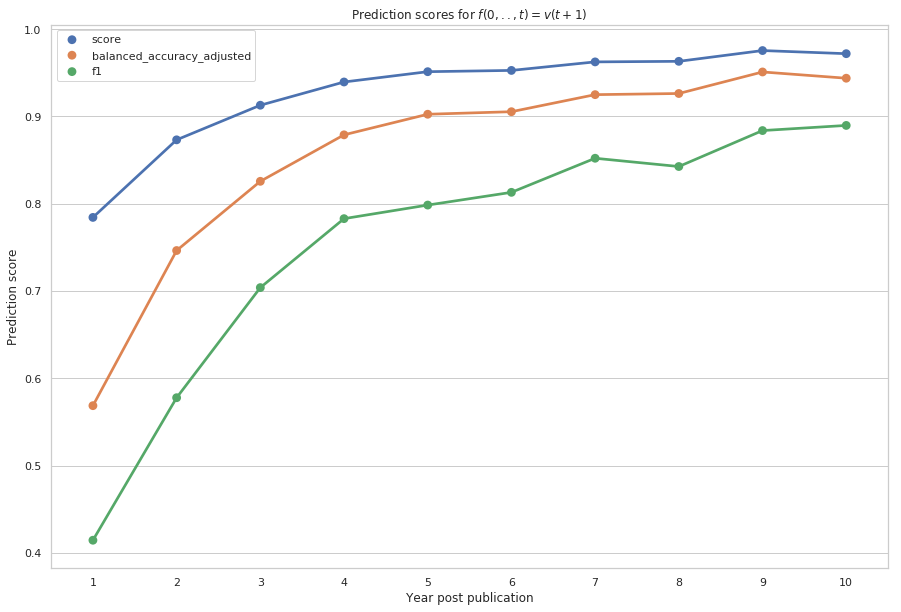

In [156]:
# Plot results over time
melted = rdf.melt(
    id_vars='year_predicted', 
    value_vars=['score','balanced_accuracy_adjusted', 'f1']
)

ax = sns.pointplot(
    data=melted, x='year_predicted', hue='variable', y='value', ci='sd'
)

ax.set_title('Prediction scores for $f(0,..,t) = v(t+1)$')
ax.set_xlabel('Year post publication')
ax.set_ylabel('Prediction score')
plt.gca().legend().set_title('')

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
600064    False
600065    False
600066    False
600067    False
600068    False
600069    False
600070    False
600071    False
600072    False
600073    False
600074    False
600075    False
600076    False
600077    False
600078    False
600079    False
600080    False
600081    False
600082    False
600083    False
600084    False
600085    False
600086    False
600087    False
600088    False
600089    False
600090    False
600091    False
600092    False
600093    False
Name: id, Length: 600094

In [229]:
y_col = 'timeScaledPageRank_{y}'.format(y=year_to_predict)
cutoff = df.loc[:, y_col].quantile(q=.9)
y = df.loc[df['id'].isin([29052283]), y_col] > cutoff
y
df.loc[df['id'].isin([29052283]), y_col]

498560    0.0
Name: timeScaledPageRank_10, dtype: float64

In [210]:
papers = {
    29052283: "CRISPR Provides Acquired Resistance Against Viruses in Prokaryotes"
    , 28214234: "Sequence information can be obtained from single DNA molecules"
    , 22084700: "Sequencing genomes from single cells by polymerase cloning"
    , 95326: "Learning representations by back-propagating errors"
    , 3869008: "RNA interference in adult mice"
    , 20645036: "Highly efficient reprogramming to pluripotency and directed differentiation of human cells with synthetic modified mRNA"
}

presults = pd.DataFrame()

for years_to_track in tqdm(range(years_tracked)):
    
    year_to_predict = years_to_track + 1
    n2v_dim = 12
    
    cols_to_keep = ['{v}_{y}'.format(y=i,v=j) 
        for i in range(years_to_track+1) 
        for j in [v for v in vars_to_use if v!='node2vec']]
    n2v_cols_to_keep =  ['node2vec_{y}_{i}'.format(y=y, i=i) 
                     for y in range(years_to_track+1)
                     for i in range(n2v_dim)]
    
    cols_to_keep = cols_to_keep + n2v_cols_to_keep
    rows_to_keep = ~df['id'].isin(papers)
    X = df.loc[rows_to_keep, cols_to_keep]
    y_col = 'timeScaledPageRank_{y}'.format(y=year_to_predict)
    cutoff = df.loc[rows_to_keep, y_col].quantile(q=.9)
    y = df.loc[rows_to_keep, y_col] > cutoff

#     mask = rdf['year_predicted']==year_to_predict
#     model = rdf.loc[mask,'random_search'].values[0]


    
    pipeline = Pipeline(
        steps=[
            ('spl', SMOTE()),
            ('scl', QuantileTransformer()),
            ('clf', RandomForestClassifier(
                n_estimators=100,
                n_jobs=-1,
                max_depth=4,
                min_samples_split=20,
                max_features='auto',
                bootstrap=True, 
                oob_score=True
            ))
        ]
    )
    
    model = pipeline.fit(X,y)
      
    # Add each paper
    for p in papers: 
        pX = df.loc[df['id']==p, cols_to_keep]
        prob = model.predict_proba(pX)

        res = pd.DataFrame(prob, columns=model.classes_)
        res.columns = ['low_impact', 'high_impact']
        res['title'] = papers[p]
        res['id'] = p
        res['years_tracked'] = years_to_track
        res['year_predicted'] = year_to_predict
        
        presults = presults.append(res)
        
    # Add Nature
    nX = df.loc[df['id'].isin(ndf['id']), cols_to_keep]
    prob = model.predict_proba(nX)
    prob.mean(axis=0)
    res = pd.DataFrame(prob, columns=model.classes_)
    res.columns = ['low_impact', 'high_impact']
    res['title'] = 'Nature (average)'
    res['id'] = 0
    res['years_tracked'] = years_to_track
    res['year_predicted'] = year_to_predict
        
    presults = presults.append(res)   

/opt/conda/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/opt/conda/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/opt/conda/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/opt/conda/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in ver

Text(0.5,0,'Year post-publication')

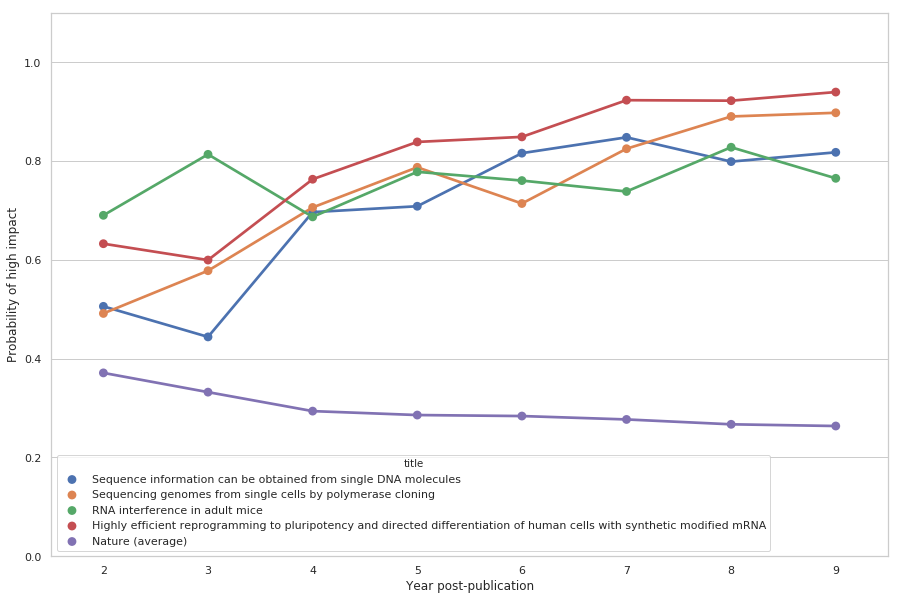

In [217]:
year_mask = (presults['years_tracked']>0)&(presults['years_tracked']<9)
id_mask = ~(presults['id'].isin([95326, 29052283]))

ax = sns.pointplot(
    data=presults.loc[year_mask & id_mask,:], 
    x='year_predicted', 
    y='high_impact', 
    hue='title'
)
ax.set_ybound([0,1.1])
ax.set_ylabel('Probability of high impact')
ax.set_xlabel('Year post-publication')


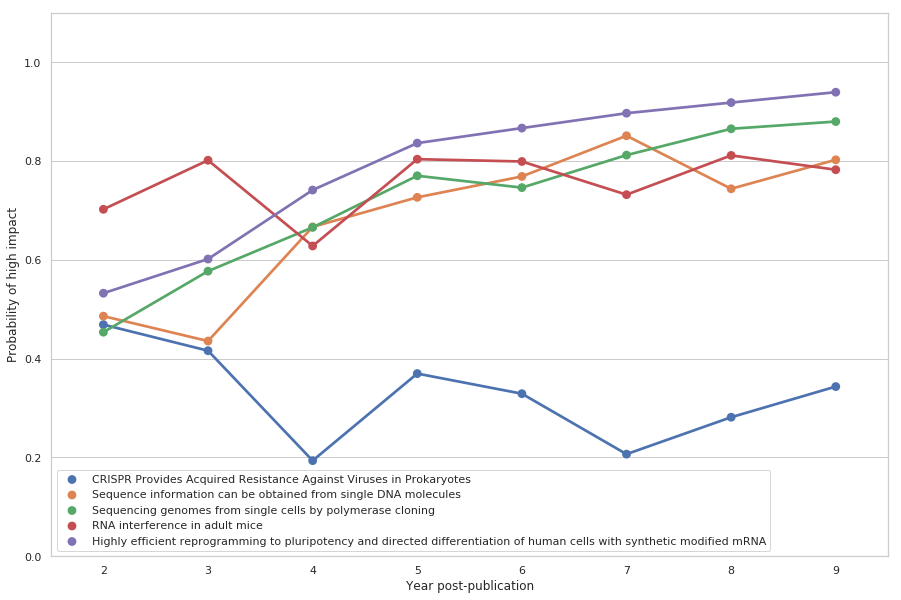

In [187]:
year_mask = (presults['years_tracked']>0)&(presults['years_tracked']<9)
id_mask = ~(presults['id'].isin([95326]))

ax = sns.pointplot(
    data=presults.loc[year_mask & id_mask,:], 
    x='year_predicted', 
    y='high_impact', 
    hue='title'
)
ax.set_ybound([0,1.1])
ax.set_ylabel('Probability of high impact')
ax.set_xlabel('Year post-publication')
plt.gca().legend().set_title('')

In [209]:


nX = df.loc[df['id'].isin(ndf['id']), cols_to_keep]
prob = model.predict_proba(nX)
prob.mean(axis=0)

array([ 0.72320896,  0.27679104])

In [211]:


df.loc[df['id'].isin([29052283]), cols_to_keep]

,adopters_0,timeScaledPageRank_0,citatons_0,adopters_1,timeScaledPageRank_1,citatons_1,adopters_2,timeScaledPageRank_2,citatons_2,adopters_3,...,node2vec_9_2,node2vec_9_3,node2vec_9_4,node2vec_9_5,node2vec_9_6,node2vec_9_7,node2vec_9_8,node2vec_9_9,node2vec_9_10,node2vec_9_11
498560,0,0.237957,0,73,0.0,0,211,0.0,0,53,...,4.13456,-11.4368,5.59272,5.53216,3.08534,-2.27501,-5.21713,-1.45581,-6.25193,1.58026


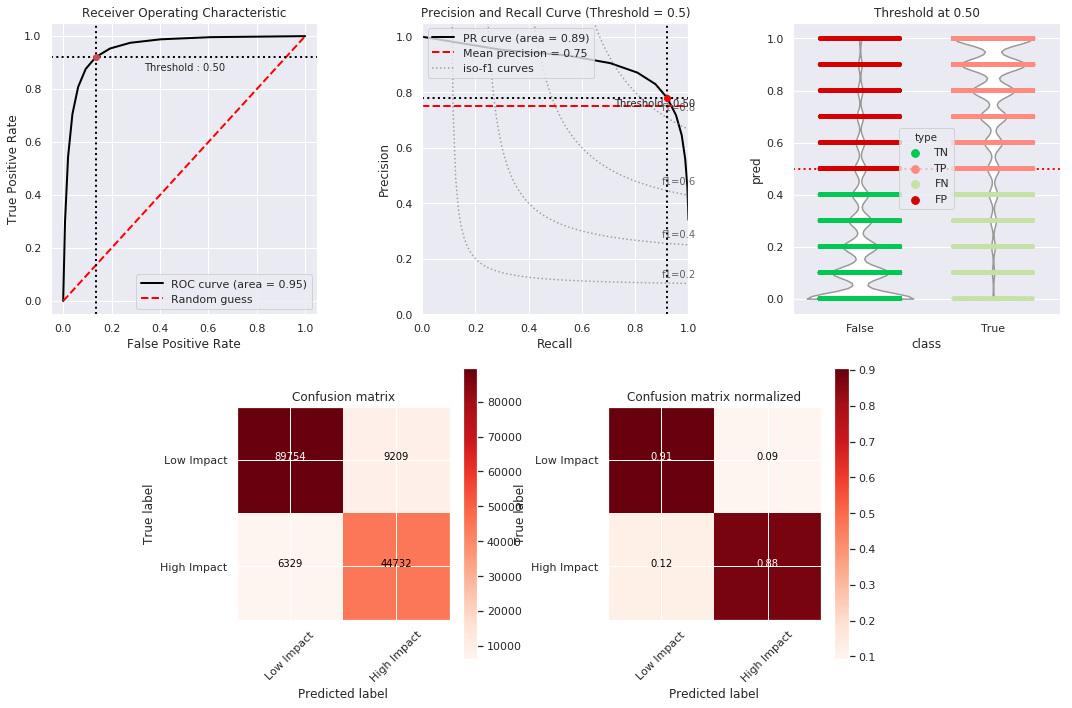

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

  Low Impact       0.93      0.91      0.92     98963
 High Impact       0.83      0.88      0.85     51061

    accuracy                           0.90    150024
   macro avg       0.88      0.89      0.89    150024
weighted avg       0.90      0.90      0.90    150024



In [19]:
from plot_metric.functions import  BinaryClassification

bc = BinaryClassification(y_test, y_prob, labels=["Low Impact", "High Impact"])

plt.figure(figsize=(15,10))

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()

plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()

plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()

plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()

plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)

plt.show()
bc.print_report()

In [306]:
y_pred = pipeline.predict(X_test)
f1_score(y_pred=y_pred, y_true=y_test)

0.5624238485906913

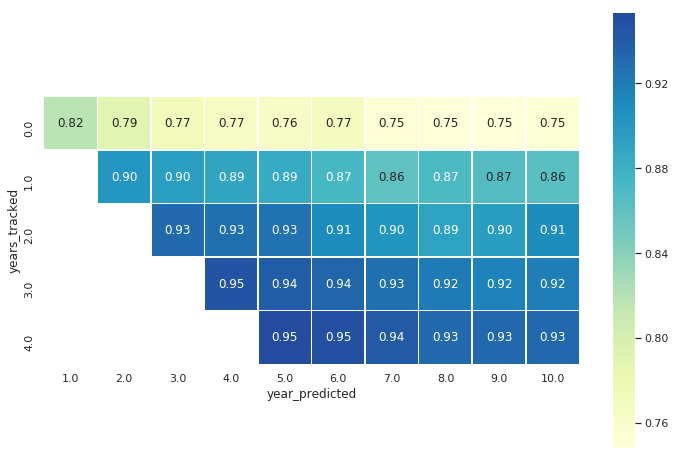

In [82]:
sns.heatmap(data=results.pivot('years_tracked', 'year_predicted', 'score'), 
           annot=True, fmt='.2f', linewidth=.5, cbar=True, square=True, 
           cmap='YlGnBu', center=results['score'].mean())

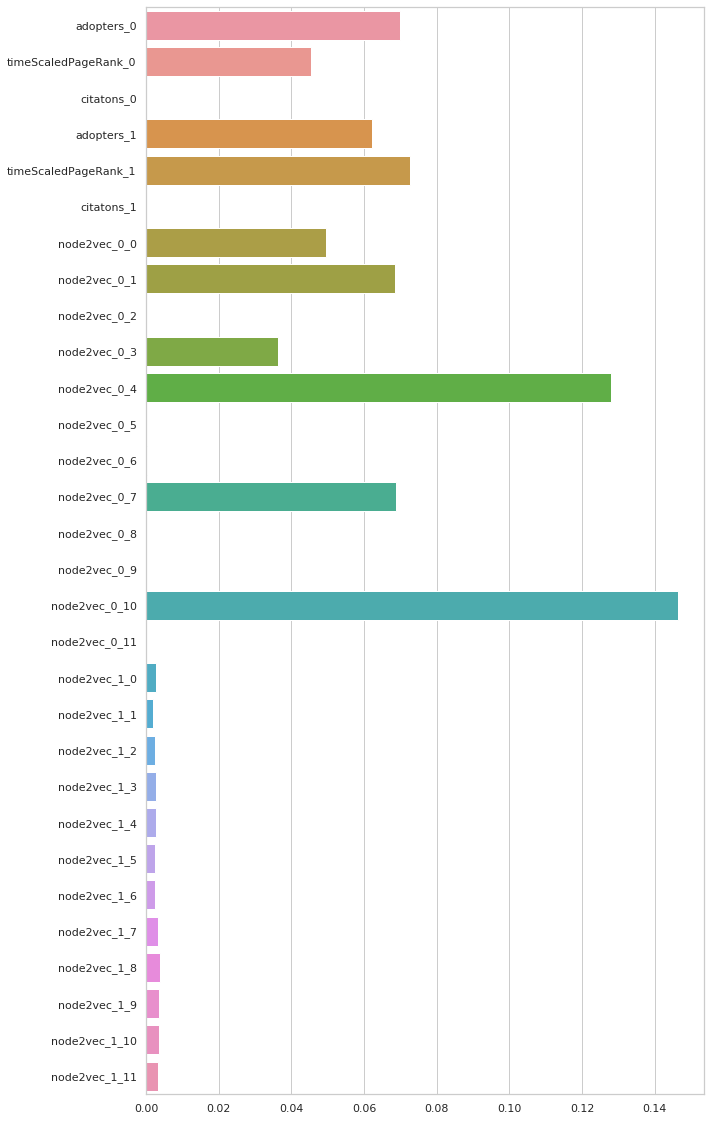

In [232]:
plt.figure(figsize=(10,20))
feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns,model.best_estimator_[2].feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

In [20]:
pipeline

Pipeline(memory=None,
         steps=[('randomundersampler',
                 RandomUnderSampler(random_state=None, ratio='auto',
                                    replacement=False, return_indices=False)),
                ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob

In [39]:
.shape

(600094, 60)

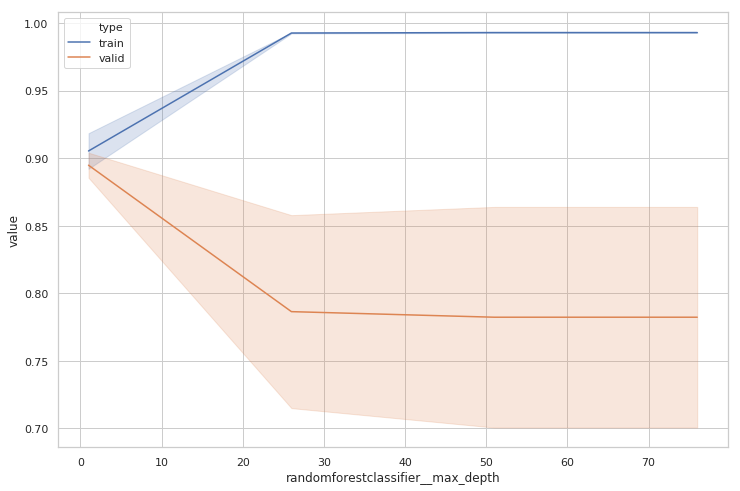

In [52]:
from sklearn.model_selection import validation_curve

param = 'randomforestclassifier__max_depth'
param_range = list(range(1,100,25))
n_cv = 2

train_scores, valid_scores = validation_curve(pipeline, 
                                              X=X, 
                                              y=y,
                                              n_jobs=-1,
                                              param_name=param,
                                              scoring='roc_auc',
                                              param_range=param_range,
                                              cv=n_cv)

vdf = pd.DataFrame(np.concatenate([train_scores, valid_scores]),
             columns=['cv_fold_{}'.format(i) for i in range(n_cv)],
            )
vdf[param] = param_range*2
vdf['type'] = ['train']*len(param_range) + ['valid']*len(param_range)

sns.lineplot(data=vdf.melt(id_vars=['type', param]), 
             x=param, y='value', hue='type')

In [45]:
pd.concat([X_train, X_test]).head()

,adopters_0,timeScaledPageRank_0,citatons_0,adopters_1,timeScaledPageRank_1,citatons_1,adopters_2,timeScaledPageRank_2,citatons_2,adopters_3,...,node2vec_3_2,node2vec_3_3,node2vec_3_4,node2vec_3_5,node2vec_3_6,node2vec_3_7,node2vec_3_8,node2vec_3_9,node2vec_3_10,node2vec_3_11
486333,4,0.116031,0,15,0.172259,0,0,0.000000,0,9,...,-0.004684,-0.013458,-0.000931,0.034042,0.183090,0.083612,-0.173805,0.111729,0.365036,0.122244
172958,0,0.000000,0,0,0.000000,0,0,0.000000,0,10,...,-0.065249,-0.034495,0.016746,0.040342,0.025095,-0.050629,-0.002370,0.066166,0.062527,-0.201143
155545,0,0.150000,0,0,0.240537,0,0,0.150000,0,0,...,-0.472903,-0.401485,-0.147171,-0.008929,0.033496,-0.004357,-0.076372,0.014749,0.703274,0.205135
327599,0,0.000000,0,0,0.000000,0,0,0.150000,0,0,...,-0.016170,-0.200942,-0.114702,0.078590,-0.083318,-0.032218,-0.082087,-0.016301,0.092598,0.286756
146966,1,0.296992,0,0,0.171250,0,0,0.031418,0,4,...,0.091882,-0.040889,0.005989,0.050186,-0.038974,-0.140391,-0.123086,0.569161,-0.086786,0.198481


In [46]:
X.columns == 

,adopters_0,timeScaledPageRank_0,citatons_0,adopters_1,timeScaledPageRank_1,citatons_1,adopters_2,timeScaledPageRank_2,citatons_2,adopters_3,...,node2vec_3_2,node2vec_3_3,node2vec_3_4,node2vec_3_5,node2vec_3_6,node2vec_3_7,node2vec_3_8,node2vec_3_9,node2vec_3_10,node2vec_3_11
0,1,3.643545,0,0,0.0,0,0,0.0,0,0,...,0.196853,0.371431,0.030722,0.038122,0.050473,-0.020753,0.164645,-0.055000,-0.002025,0.022914
1,0,0.034130,0,0,0.0,0,0,0.0,0,0,...,0.075058,0.115643,0.008120,-0.007331,0.052746,-0.021005,-0.033460,0.014831,-0.027466,-0.019136
2,0,0.034130,0,0,0.0,0,0,0.0,0,0,...,0.010327,0.080612,0.008475,-0.030307,0.070742,-0.025837,0.043135,-0.026692,0.021995,-0.033936
3,0,0.034130,0,0,0.0,0,0,0.0,0,1,...,0.018409,0.019502,0.009520,-0.003356,0.071898,-0.004367,-0.124106,0.011427,0.015794,0.033859
4,0,0.034130,0,0,0.0,0,0,0.0,0,0,...,0.024362,0.001470,0.031148,0.020692,0.039797,0.019841,0.098249,-0.005099,-0.031990,-0.016112


### Predictions

In [11]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, n_jobs=-1, 
                                                    scoring='r2', config_dict='TPOT light', 
                                                    max_time_mins=30, max_eval_time_mins=5) 
tpot.fit(X_train, y_train)



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeRegressor(MinMaxScaler(input_matrix), max_depth=9, min_samples_leaf=19, min_samples_split=6)


TPOTRegressor(config_dict='TPOT light', crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=1000000,
       max_eval_time_mins=5, max_time_mins=30, memory=None,
       mutation_rate=0.9, n_jobs=-1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=20,
       random_state=None, scoring='r2', subsample=1.0, template=None,
       use_dask=False, verbosity=2, warm_start=False)

In [13]:
tpot.score(X_test, y_test)

0.32070619981531434

In [14]:
tpot.export('tpot_exported_pipeline.py')

In [1]:
!cat tpot_exported_pipeline.py

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:0.24912375544428125
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    DecisionTreeRegressor(max_depth=9, min_samples_leaf=19, min_samples_split=6)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [6]:
years_ahead = 4
df = pd.read_csv('/tmp/data/quanta.predict.{miny}.{maxy}.{ya}.csv.out'.format(
        miny=min_year, maxy=max_year, ya=years_ahead))
df.shape

(773198, 36)

In [4]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running